### **Análisis Exploratorio de Datos**

In [2]:
#Se importan las librerias correspondientes
import os
import pyspark
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import year
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import  IntegerType, StringType, DateType
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd


In [3]:
#Se confirma que los datos se encuentren en el espacio de trabajo 
if  not (os.path.isdir("raw") and os.path.isfile(os.path.join("trusted", 'trafico_aereo_1992_2022.csv'))):
    import preprocess
    preprocess

In [4]:
# creamos el contexto y la sesión
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()
spark

In [5]:

#Se define el esquema de la tabla
schema = StructType([
    StructField('Fecha', DateType()),
    StructField('Sigla Empresa', StringType()),
    StructField('Origen', StringType()),
    StructField('Destino', StringType()),
    StructField('Pasajeros', IntegerType()),
    StructField('Trafico', StringType()),
    StructField('TipoVuelo', StringType()),
    StructField('Ciudad Origen', StringType()),
    StructField('Ciudad Destino', StringType()),
    StructField('Pais Origen', StringType()),
    StructField('Pais Destino', StringType()),
    StructField('Nombre Empresa', StringType()),
    StructField('Apto_Origen', StringType()),
    StructField('Apto_Destino', StringType()),
])

In [6]:
#Se lee el archivo de trusted
filepath = os.path.join("trusted", 'trafico_aereo_1992_2022.csv')
df = spark.read.csv(filepath, header=True, schema=schema)
df.show(n=3)

+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+
|     Fecha|Sigla Empresa|Origen|Destino|Pasajeros|Trafico|TipoVuelo|Ciudad Origen|Ciudad Destino|   Pais Origen|Pais Destino|Nombre Empresa|         Apto_Origen|        Apto_Destino|
+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+
|2019-04-01|          AAL|   ABQ|    BOG|       37|      I|        R| NUEVO MEXICO|        BOGOTA|ESTADOS UNIDOS|    COLOMBIA|      AMERICAN|ALBUQUERQUE INTL ...|   BOGOTA - ELDORADO|
|2019-04-01|          AAL|   ABZ|    CLO|        1|      I|        R|     ABENDEEN|          CALI|    INGLATERRA|    COLOMBIA|      AMERICAN|                CYDE|CALI - ALFONSO BO...|
|2019-04-01|          AAL|   AMS|    CTG|        2|      I|        R|    AMSTERD

In [7]:
print((df.count(), len(df.columns)))

(1820258, 14)


In [8]:
#Cantidad de valores nulos
for c in df.columns:
    nuls = df.filter(col(c).isNull()).count()
    print(f'{c} - {nuls}')

Fecha - 15
Sigla Empresa - 12
Origen - 24
Destino - 15
Pasajeros - 201
Trafico - 24
TipoVuelo - 24
Ciudad Origen - 8351
Ciudad Destino - 9116
Pais Origen - 8351
Pais Destino - 73
Nombre Empresa - 15
Apto_Origen - 18
Apto_Destino - 30


In [9]:
df = df.na.drop(subset=["Pasajeros", "Nombre Empresa"])


In [10]:
#Cantidad de valores nulos
for c in df.columns:
    nuls = df.filter(col(c).isNull()).count()
    print(f'{c} - {nuls}')

In [11]:
#Se toma la decision de unificar los nombres de las aerolineas a aquellas que han cambiado de nombre
# debido a unificaciones o compras, las transformaciones se pueden observar en el diccionario:
dict_aerolineas={ "LATAM":["AIRES" "LAN", "TAM", ],
                 "FAST COLOMBIA":"VIVA AIR"
    
}

In [12]:
#Se crea una nueva columna a partir de la limpieza de la columna 'Nombre empresa'
df = df.select("*",
            when(df["Nombre Empresa"].contains("21 AIR LLC."), "21 AIR").
            when(df["Nombre Empresa"].contains("REGAIR"), "REGAIR").
            when(df["Nombre Empresa"].contains("ABX AIR INC"), "ABX AIR INC").
            when(df["Nombre Empresa"].contains("AER CARIBE"), "AER CARIBE").
            when(df["Nombre Empresa"].contains("DAMOJH"), "DAMOJH").
            when(df["Nombre Empresa"].contains("AEROUNIËN"), "AEROUNIÓN").
            when(df["Nombre Empresa"].contains("ALBATROS"), "ALBATROS AIRLINES").
            when(df["Nombre Empresa"].contains("AMERICA┤S AIR SAS"), "AMERICA´S AIR SAS").
            when(df["Nombre Empresa"].contains("AVIANLINE CHARTE┤S S.A.S."), "AVIANLINE CHARTE´S S.A.S.").
            when(df["Nombre Empresa"].contains("CARGO THREE INC."), "CARGO THREE").
            when(df["Nombre Empresa"].contains("FLEXAIR S A S"), "FLEXAIR S.A.S").
            when(df["Nombre Empresa"].contains("HORIZONTAL DE AVIACION S.A.S"), "HORIZONTAL S A S").
            when(df["Nombre Empresa"].contains("ICARO S.A."), "ICARO").
            when(df["Nombre Empresa"].contains("LATAM AIRLINES GROUP S.A SUCURSAL COLOMBIA"), "LATAM").
            when(df["Nombre Empresa"].contains("CARGUERA DE COLOMBIA S.A"), "LÍNEA AÉREA CARGUERA DE COLOMBIA S.A.").
            when(df["Nombre Empresa"].contains("NO FIGURA"), "NO REGISTRA").
            when(df["Nombre Empresa"].contains("NO REGISTRA SIGLA"), "NO REGISTRA").
            when(df["Nombre Empresa"].contains("SERVICIO AEREO A TERRITORIOS NACIONALES SATENA"), "SATENA").
            when(df["Nombre Empresa"].contains("SKY LEASE I. INC  (GREENSBORO.NC)"), "SKY LEASE").
            when(df["Nombre Empresa"].contains("SKY LEASE I. INC (GREENSBORO.NC)"), "SKY LEASE").
            when(df["Nombre Empresa"].contains("SOUTHERN AIR TRANSPORT INC."), "SOUTHERN AIR INC.").
            when(df["Nombre Empresa"].contains("TAG"), "TAG AVIATION").
            when(df["Nombre Empresa"].contains("TAMPA CARGO"), "TAMPA CARGO").
            when(df["Nombre Empresa"].contains("VIANA S.A.S"), "VIANA S.A.S").
            when(df["Nombre Empresa"].contains("TAXCO S.A.S"), "TAXCO").
            when(df["Nombre Empresa"].contains("VUELA COMPAÑÍA DE AVIACION S.A.P.I DE"), "VUELA COMPAÑÍA DE AVIACION").
            when(df["Nombre Empresa"].contains("AERO LLANOS DEL ORIENTE"), "AERO LLANOS DEL ORIENTE").
            when(df["Nombre Empresa"].contains("ASES LTDA."), "ASES LTDA.").
            when(df["Nombre Empresa"].contains("AERO TAXI GUAYMARAL ATG S.A.S"), "AERO TAXI GUAYMARAL").
            when(df["Nombre Empresa"].contains("MITCHELL AAERO, INC."), "MITCHELL AAERO, INC.").
            when(df["Nombre Empresa"].contains("ROYAL AIR MAROC-COMPAGNIE"), "ROYAL AIR MAROC-COMPAGNIE").
            when(df["Nombre Empresa"].contains("AIR TRANSPORT ASSOCIATION OF AMERCA"), "AIR TRANSPORT ASSOCIATION OF AMERCA").
            when(df["Nombre Empresa"].contains("OMEGA AIR HOLDING"), "OMEGA AIR HOLDING").
            when(df["Nombre Empresa"].contains("KALITTA FLYING SERVICE"), "KALITTA FLYING SERVICE").
            when(df["Nombre Empresa"].contains("LINEA AEREA BOLIVARIANA"), "LINEA AEREA BOLIVARIANA").
            when(df["Nombre Empresa"].contains("TRANS AMERICAN AIR LINES"), "TRANS AMERICAN AIR LINES").
            when(df["Nombre Empresa"].contains("UNITED PARCEL SERVICE"), "UNITED PARCEL SERVICE").
            when(df["Nombre Empresa"].contains("AMERIJET INTERNATIOANL"), "AMERIJET INTERNATIONAL").
            when(df["Nombre Empresa"].contains("AEROTRANSPORTE DE CARGA UNION"), "AEROTRANSPORTE DE CARGA UNION").
            when(df["Nombre Empresa"].contains("DUTCH ANTILLES EXPRESS"), "DUTCH ANTILLES EXPRESS").
            when(df["Nombre Empresa"].contains("AEROGALAN"), "STARBLUE AIRLINES"). #Aerogalan cambia nombre a starblue
            when(df["Nombre Empresa"].contains("VRG LINHAS AEREAS"), "VRG LINHAS AEREAS").
            when(df["Nombre Empresa"].contains("DYNAMIC AIRWAYS"), "DYNAMIC AIRWAYS").
            when(df["Nombre Empresa"].contains("AVIANCA"), "AVIANCA").
            when(df["Nombre Empresa"].contains("JETBLUE AIRWAYS CORPORATION"), "JETBLUE AIRWAYS").
            when(df["Nombre Empresa"].contains("AIR CLASS"), "AIR CLASS").
            when(df["Nombre Empresa"].contains("VERTICAL DE AVIACION"), "VERTICAL DE AVIACION").
            when(df["Nombre Empresa"].contains("REGIONAL EXPRESS AMERICAS"), "REGIONAL EXPRESS AMERICAS").
            when(df["Nombre Empresa"].contains("AEROMEXICO"), "AEROMEXICO").
            when(df["Nombre Empresa"].contains("AEROLINEA DE ANTIOQUIA"), "ADA").
            when(df["Nombre Empresa"].contains("LATAM"), "LATAM").
            when(df["Nombre Empresa"].contains("FAST COLOMBIA"), "VIVA AIR").
            when(df["Nombre Empresa"].contains("AIRES"), "LATAM").
            when(df["Nombre Empresa"].contains("LAN"), "LATAM").
            when(df["Nombre Empresa"].contains("TAM"), "LATAM").
            when(df["Nombre Empresa"].contains("AEROEXPRESO DEL PACIFICO S.A."), "AEXPA").
            	
            otherwise(df["Nombre Empresa"]).alias("Nombre_Empresa_clean")
           )




In [13]:
import pyspark.sql.functions as F
#df.select("Nombre_Empresa_clean", F.length(col("Nombre_Empresa_clean")).alias("len")
#          ).distinct().sort("len",descending=False).show(n=100000, truncate=False)

#df.select("Nombre_Empresa_clean").distinct().sort("Nombre_Empresa_clean",descending=False).show(n=100000, truncate=False)

+---------------------------------------+
|Nombre_Empresa_clean                   |
+---------------------------------------+
|21 AIR                                 |
|A.T.&S.                                |
|ABSA                                   |
|ABX AIR INC                            |
|ACES                                   |
|ADA                                    |
|ADES                                   |
|AER CARIBE                             |
|AEREA S.A.                             |
|AERO APOYO                             |
|AERO COSTA RICA                        |
|AERO LLANOS DEL ORIENTE                |
|AERO PAZ S.A.                          |
|AERO TAXI GUAYMARAL                    |
|AEROAMERICA                            |
|AEROANTIGUA                            |
|AEROCAFE S.A.                          |
|AEROCAR                                |
|AEROCHARTER ANDINA S.A.S.              |
|AEROCHARTER DE COLOMBIA                |
|AEROCOL S.A.S                    

**¿Cómo ha evolucionado el tráfico aéreo, visto como el número de pasajeros, a través de los años?**

In [15]:
pasajeros_anho = df.select(
                "Fecha",
                "Pasajeros", 
                year("Fecha").alias("año")
                ).groupBy("año").agg(
                    sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [16]:
pasajeros_anho_empresa = df.select(
                        "Pasajeros",
                        "Nombre_Empresa_clean",
                        year("Fecha").alias("año")
                        ).groupBy(["año", "Nombre_Empresa_clean"]).agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [17]:
pasajeros_empresa = df.select(
                        "Pasajeros",
                        "Nombre_Empresa_clean",
                        ).groupBy("Nombre_Empresa_clean").agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [18]:
pasajeros_anho_empresa_nacional = df.select(
                        "Pasajeros",
                        "Nombre_Empresa_clean",
                        year("Fecha").alias("año")
                        ).filter(df.Trafico=="N").groupBy(["año", "Nombre_Empresa_clean"]).agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

<Axes: xlabel='año'>

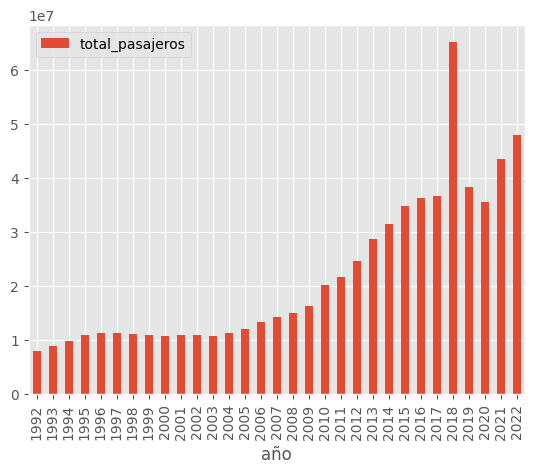

In [19]:
pasajeros_anho["año"] = pasajeros_anho["año"].astype("Int64")
pasajeros_anho.dropna(inplace=True)
pasajeros_anho.set_index("año").sort_index().plot(kind="bar")


<Axes: ylabel='Nombre_Empresa_clean'>

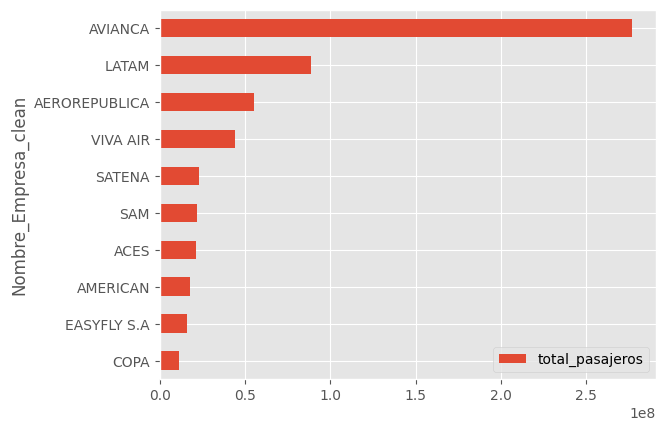

In [20]:
pasajeros_empresa.dropna(inplace=True)
pasajeros_empresa.sort_values("total_pasajeros", ascending=False)[:10].sort_values("total_pasajeros").set_index("Nombre_Empresa_clean").plot(kind="barh")


In [21]:
top_empresas =pd.DataFrame()
tot_anhos = pasajeros_anho_empresa["año"].unique()
for anho in tot_anhos:
    ind = pasajeros_anho_empresa["año"] ==anho
    tmp = pasajeros_anho_empresa.loc[ind,:].sort_values("total_pasajeros", ascending=False).iloc[:10,:]
    top_empresas = pd.concat([top_empresas,tmp ])
top_empresas = top_empresas.sort_values("año")

In [22]:
top_empresas_nacional =pd.DataFrame()
tot_anhos_nacional = pasajeros_anho_empresa_nacional["año"].unique()
for anho in tot_anhos_nacional:
    ind = pasajeros_anho_empresa_nacional["año"] ==anho
    tmp = pasajeros_anho_empresa_nacional.loc[ind,:].sort_values("total_pasajeros", ascending=False).iloc[:10,:]
    top_empresas_nacional = pd.concat([top_empresas_nacional,tmp ])
top_empresas_nacional = top_empresas_nacional.sort_values("año")

**IpyVizzu**

In [53]:
 # data processing, CSV file I/O (e.g. pd.read_csv)
from ipyvizzu import Chart, Data, Config, Style
char_data = Data()
char_data.add_data_frame(top_empresas_nacional) #Adds data to chart
chart = Chart(display = "begin")
chart.scroll_into_view = False


chart.animate(char_data)
config = {
    "channels": {
        "x": {"set": ["total_pasajeros"]},
        "y": {"set": ["Nombre_Empresa_clean"]},
        "color": {"set": ["Nombre_Empresa_clean"]},
        "label": { "set": ["total_pasajeros"] }
    },
    "sort": 'byValue',
    "legend": None,
}

style= Style({"plot": 
    {"marker": {"colorPalette": "#008080 #b5e48cff #99D986 #76c893ff #52b69aff"
                + " #34a0a4ff #168aadff #1a759fff #1e6091ff #184e77ff",
                "label": {"maxFractionDigits": "0"}}, #cutting off unnecessary digits when animating the labels
      "paddingLeft":"18em", #add padding on the left side of the plot so that long country names are visible
      "xAxis": { "title": { "color" : "#00000000" }} #hiding the axis title on the x-axis
    }})

#Renders the animation for each year
for anho in range(1992, 2023):
    config["title"] = f"Número de pasajeros por aerolínea en {anho}"
    chart.animate(
        Data.filter("record['año'] == {}".format(anho)), 
        Config(config),
        style,
        # Animation options:
        duration = .9,        
        x = { "easing": "linear", "delay": 0 },
        y = { "delay": 0 },
        show = { "delay": 0 },
        hide = { "delay": 0 },
        title = { "duration": 0, "delay": 0 })
 


In [29]:
char_data = Data()
char_data.add_data_frame(top_empresas_nacional) 
chart = Chart(display = "begin")
chart.scroll_into_view = False


chart.animate(char_data)
config = {
    "channels": {
        "x": {"set": ["total_pasajeros"]},
        "y": {"set": ["Nombre_Empresa_clean"]},
        "color": {"set": ["Nombre_Empresa_clean"]},
        "label": { "set": ["total_pasajeros"] }
    },
    "sort": 'byValue',
    "legend": None,
}

style= Style({"plot": 
    {"marker": {"colorPalette": "#d9ed92ff #b5e48cff #99D986 #76c893ff #52b69aff"
                + " #34a0a4ff #168aadff #1a759fff #1e6091ff #184e77ff",
                "label": {"maxFractionDigits": "0"}}, #cutting off unnecessary digits when animating the labels
      "paddingLeft":"19em", #add padding on the left side of the plot so that long country names are visible
      "xAxis": { "title": { "color" : "#00000000" }} #hiding the axis title on the x-axis
    }})


for anho in range(1992, 2023):
    config["title"] = f"Número de pasajeros por aerolínea en {anho}"
    chart.animate(
        Data.filter("record['año'] == {}".format(anho)), 
        Config(config),
        style,
        # Animation options:
        duration = .8,        
        x = { "easing": "linear", "delay": 0 },
        y = { "delay": 0 },
        show = { "delay": 0 },
        hide = { "delay": 0 },
        title = { "duration": 0, "delay": 0 })
 
 




*Export Data*

In [31]:
df.columns

['Fecha',
 'Sigla Empresa',
 'Origen',
 'Destino',
 'Pasajeros',
 'Trafico',
 'TipoVuelo',
 'Ciudad Origen',
 'Ciudad Destino',
 'Pais Origen',
 'Pais Destino',
 'Nombre Empresa',
 'Apto_Origen',
 'Apto_Destino',
 'Nombre_Empresa_clean']

In [32]:
trafico_historico = df.groupBy(["Sigla Empresa", "Origen","Destino", "Trafico", "TipoVuelo","Ciudad Origen",
            'Ciudad Destino',
 'Pais Origen',
 'Pais Destino','Apto_Origen',
 'Apto_Destino',
 'Nombre_Empresa_clean']).agg(sum("Pasajeros").alias("pasajeros")).toPandas()

In [33]:
trafico_historico.isnull().sum()

Sigla Empresa              0
Origen                     0
Destino                    0
Trafico                    0
TipoVuelo                  0
Ciudad Origen           1475
Ciudad Destino          1589
Pais Origen             1475
Pais Destino              16
Apto_Origen                0
Apto_Destino               2
Nombre_Empresa_clean       0
pasajeros                  0
dtype: int64

In [34]:
trafico_historico.to_excel("trafico_aerolineas.xlsx")